<a href="https://colab.research.google.com/github/tejshahi/data_fusion/blob/master/CNN_train_6band(Nepal_case).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Check the GPU status

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import the necessary Library and Files

In [3]:
from osgeo import gdal_array
from osgeo import gdal
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# Load the data set

In [4]:
filepath= "/content/drive/MyDrive/dataset_for_fusion/ls_sa_ndvi_training_set_c.dat" #change the file path if necessary
raster = gdal.Open(filepath)
rasterArray = raster.ReadAsArray()
b1 = rasterArray[0,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b2 = rasterArray[1,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b3 = rasterArray[2,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b4 = rasterArray[3,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b5 = rasterArray[4,0:rasterArray.shape[1],0:rasterArray.shape[2]]
b6 = rasterArray[5,0:rasterArray.shape[1],0:rasterArray.shape[2]]

In [5]:
rasterArray.shape

(6, 2661, 3395)

# Reshape the input into individual band

In [6]:
b11=np.reshape(b1,(b1.shape[0]*b1.shape[1],))
b22=np.reshape(b2,(b2.shape[0]*b2.shape[1],))
b33=np.reshape(b3,(b3.shape[0]*b3.shape[1],))
b44=np.reshape(b4,(b4.shape[0]*b4.shape[1],))
b55=np.reshape(b5,(b5.shape[0]*b5.shape[1],))
b66=np.reshape(b6,(b6.shape[0]*b6.shape[1],))

In [7]:
b11.shape

(9034095,)

# Divide the image into small sliding tiles

In [8]:
train_x=np.stack((b11,b33,b44,b55,b66),axis=-1)

In [9]:
train_x.shape
tile_size=5

In [10]:
list_small_tiles=[]
list_small_tiles.clear()
for i in range(train_x.shape[0]-tile_size):
  list_small_tiles.append(train_x[i:i+tile_size])
list_small_tiles.append(train_x[i:i+tile_size])
list_small_tiles.append(train_x[i+1:i+tile_size+1])

In [11]:
len(list_small_tiles)

9034092

In [12]:
x=np.array(list_small_tiles)

In [13]:
x=np.reshape(x,(x.shape[0],x.shape[1],x.shape[2],1))

In [14]:
train_y=b22[:-tile_size+2]

In [15]:
print(x.shape)
print(train_y.shape)

(9034092, 5, 5, 1)
(9034092,)


# Design CNN Network using Keras API

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten, Conv2D, Conv1D,BatchNormalization, MaxPool2D,GlobalAvgPool1D
from keras import backend
model=Sequential()
model.add(Conv2D(filters=25, kernel_size=2, activation='relu',padding='same', input_shape=(5,5,1)))
model.add(MaxPool2D(2))
model.add(Conv2D(filters=50,kernel_size=2,activation='relu',padding='same'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(1))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 5, 5, 25)          125       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 25)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 50)          5050      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 5,226
Trainable params: 5,226
Non-trainable params: 0
____________________________________________________

In [27]:
import time
train_s_time=time.clock()
model.compile(loss='mse', optimizer='adam',metrics=['mse','mae'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [28]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',verbose=1)
history=model.fit(x, 
    train_y, 
    epochs=20,
    batch_size=100,
    validation_split=0.2,
    verbose=2,
    callback=[es]
    )
print("training time"+str(time.clock()-train_s_time)+'secs.')

Epoch 1/20
72273/72273 - 192s - loss: 9.6527e-04 - mse: 9.6527e-04 - mae: 0.0226 - val_loss: 9.0016e-04 - val_mse: 9.0016e-04 - val_mae: 0.0223
Epoch 2/20
72273/72273 - 190s - loss: 8.8144e-04 - mse: 8.8144e-04 - mae: 0.0216 - val_loss: 9.0604e-04 - val_mse: 9.0604e-04 - val_mae: 0.0221
Epoch 3/20
72273/72273 - 188s - loss: 8.6503e-04 - mse: 8.6503e-04 - mae: 0.0214 - val_loss: 8.4176e-04 - val_mse: 8.4176e-04 - val_mae: 0.0215
Epoch 4/20
72273/72273 - 187s - loss: 8.5600e-04 - mse: 8.5600e-04 - mae: 0.0212 - val_loss: 8.7605e-04 - val_mse: 8.7605e-04 - val_mae: 0.0218
Epoch 5/20
72273/72273 - 171s - loss: 8.5186e-04 - mse: 8.5186e-04 - mae: 0.0212 - val_loss: 8.4651e-04 - val_mse: 8.4651e-04 - val_mae: 0.0215
Epoch 6/20
72273/72273 - 188s - loss: 8.4857e-04 - mse: 8.4857e-04 - mae: 0.0211 - val_loss: 8.3524e-04 - val_mse: 8.3524e-04 - val_mae: 0.0213
Epoch 7/20
72273/72273 - 196s - loss: 8.4601e-04 - mse: 8.4601e-04 - mae: 0.0211 - val_loss: 9.8193e-04 - val_mse: 9.8193e-04 - val_mae:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


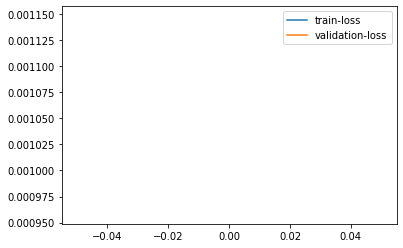

In [20]:
#plot history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train-loss')
pyplot.plot(history.history['val_loss'], label='validation-loss')
pyplot.legend()
pyplot.show()

In [21]:
#save the model for later uses
model.save("CNN-Train-Six.h5",overwrite=True)

In [22]:
#load test file of Nepal case data

In [23]:
filename="/content/drive/My Drive/GIS/ls_sa_ndvi_testing_set_c.dat"
raster = gdal.Open(filename)
rasterArray = raster.ReadAsArray()
tb1 = rasterArray[0,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb2 = rasterArray[1,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb3 = rasterArray[2,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb4 = rasterArray[3,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb5 = rasterArray[4,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb6 = rasterArray[5,0:rasterArray.shape[1],0:rasterArray.shape[2]]
tb1_reshape=np.reshape(tb1,(tb1.shape[0]*tb1.shape[1],))
tb3_reshape=np.reshape(tb3,(tb3.shape[0]*tb3.shape[1],))
tb4_reshape=np.reshape(tb4,(tb4.shape[0]*tb4.shape[1],))
tb5_reshape=np.reshape(tb5,(tb5.shape[0]*tb5.shape[1],))
tb6_reshape=np.reshape(tb6,(tb6.shape[0]*tb6.shape[1]))
tb2_reshape=np.reshape(tb2,(tb2.shape[0]*tb2.shape[1],))

AttributeError: ignored

In [ ]:
tile_size=5

In [ ]:
test_x=np.stack((tb1_reshape,tb3_reshape,tb4_reshape,tb5_reshape, tb6_reshape),axis=-1)
test_y=tb2_reshape


In [ ]:
list_small_tiles=[]
list_small_tiles.clear()
for i in range(test_x.shape[0]-tile_size):
  list_small_tiles.append(test_x[i:i+tile_size])
list_small_tiles.append(test_x[i:i+tile_size])
list_small_tiles.append(test_x[i+1:i+tile_size+1])

In [ ]:
test_x=np.array(list_small_tiles)
test_x=np.reshape(test_x,(test_x.shape[0],tile_size,tile_size,1))

In [ ]:
test_y=test_y[:-tile_size+2]

In [ ]:
#check for x and y shape
print(test_x.shape)
print(test_y.shape)

In [ ]:
from keras.models import load_model
model=load_model('/content/CNN-Train-Six-band.h5')

In [ ]:
#whole test data performance evaluations
pred_y=model.predict(test_x)
print("r2 score: %.6f" %r2_score(test_y,pred_y))
rmse = sqrt(mean_squared_error(test_y,pred_y))
print('Test RMSE: %.3f' % rmse)
# calculate MAE
mae = mean_absolute_error(test_y,pred_y)
print('Test MAE: %.3f' % mae)

In [ ]:
tb2_reshape.shape

In [ ]:
a=np.pad(pred_y.ravel(), (1,2),"edge")
a.shape

In [ ]:
np.savetxt("CNN_six_band_nepal.csv", a, delimiter=",")

In [ ]:
#divide the test cases

In [ ]:
j=0
case1_x=[]
case1_y=[]
case2_x=[]
case2_y=[]
case3_x=[]
case3_y=[]
case4_x=[]
case4_y=[]
case5_x=[]
case5_y=[]
case6_x=[]
case6_y=[]
case7_x=[]
case7_y=[]
case8_x=[]
case8_y=[]
case9_x=[]
case9_y=[]
for i in range(tb1.size):
    if(tb1_reshape[i]<tb2_reshape[i]<tb3_reshape[i]):
        case1_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case1_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]<tb2_reshape[i]==tb3_reshape[i]):
        case2_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case2_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]<tb2_reshape[i]>tb3_reshape[i]):
        case3_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case3_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]==tb2_reshape[i]<tb3_reshape[i]):
        case4_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case4_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]==tb2_reshape[i]==tb3_reshape[i]):
        case5_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case5_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]==tb2_reshape[i]>tb3_reshape[i]):
        case6_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case6_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]>tb2_reshape[i]<tb3_reshape[i]):
        case7_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case7_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]>tb2_reshape[i]==tb3_reshape[i]):
        case8_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case8_y.append(tb2_reshape[i])
    elif(tb1_reshape[i]>tb2_reshape[i]>tb3_reshape[i]):
        case9_x.append([tb1_reshape[i],tb3_reshape[i],tb4_reshape[i],tb5_reshape[i],tb6_reshape[i]])
        case9_y.append(tb2_reshape[i])

In [ ]:
def prepare_case(x,y):
  x=np.array(x)
  y=np.array(y)
  small_tiles=[]
  small_tiles.clear()
  for i in range(x.shape[0]-tile_size):
    small_tiles.append(x[i:i+tile_size])
  small_tiles.append(x[i:i+tile_size])
  small_tiles.append(x[i+1:i+tile_size+1])
  test_x=np.array(small_tiles)
  test_x=np.reshape(test_x,(test_x.shape[0],tile_size,tile_size,1))
  test_y=y[:-tile_size+2]
  return (test_x,test_y)

In [ ]:
def predict_case(test_x,test_y):
    pred_y=model.predict(test_x)
    print("r2 score: %.6f" %r2_score(test_y,pred_y))
    rmse = sqrt(mean_squared_error(test_y,pred_y))
    print('Test RMSE: %.3f' % rmse)
    # calculate MAE
    mae = mean_absolute_error(test_y,pred_y)
    print('Test MAE: %.3f' % mae)
    return pred_y

In [ ]:
x1,y1=prepare_case(case1_x,case1_y)
y1_hat=predict_case(x1,y1)

In [ ]:
x3,y3=prepare_case(case3_x,case3_y)
y3_hat=predict_case(x3,y3)

In [ ]:
x7,y7=prepare_case(case7_x,case7_y)
y7_hat=predict_case(x7,y7)

In [ ]:
x9,y9=prepare_case(case9_x,case9_y)
y9_hat=predict_case(x9,y9)